In [53]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.layers as tfl

#tfds.disable_progress_bar()

In [31]:
# Loading the dataset
catdog_dataset, catdog_info = tfds.load(name='cats_vs_dogs:4.0.0', split='train', 
                                        shuffle_files=True, with_info=True, as_supervised=True)

In [32]:
cd_info.splits['train'].num_examples

23262

In [33]:
# Shuffling the data
buffer_size = 100
shuffled_dataset = catdog_dataset.shuffle(buffer_size)

# Redusing the size of the dataset (take 1000 examples)
num_dataset_samples = 1000
num_validation_samples = 100
train_data = shuffled_dataset.take(num_dataset_samples)
validation_data = train_data.take(num_validation_samples)

type(validation_data)

tensorflow.python.data.ops.dataset_ops.TakeDataset

In [34]:
IMG_SIZE = (160, 160)
input_scaling = (127.5, 127.5)

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image - input_scaling[1]) / input_scaling[0]
    image = tf.image.resize(image, IMG_SIZE)
    return image, label

BATCH_SIZE = 64
train_dataset = train_data.map(format_example).batch(BATCH_SIZE)
validation_dataset = validation_data.map(format_example).batch(BATCH_SIZE)

In [35]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [36]:
labels = np.array([])
for _, label_batch in train_dataset:
    labels = np.concatenate((labels, label_batch))

num_images = labels.shape[0]

print(f"Test set composed of {num_images} images: "
      f"{np.count_nonzero(labels==0)} cats and "
      f"{np.count_nonzero(labels==1)} dogs.")

Test set composed of 1000 images: 499 cats and 501 dogs.


### Transfer Model

In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [38]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [39]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

block_4_expand_relu (ReLU)      (None, 20, 20, 192)  0           block_4_expand_BN[0][0]          
__________________________________________________________________________________________________
block_4_depthwise (DepthwiseCon (None, 20, 20, 192)  1728        block_4_expand_relu[0][0]        
__________________________________________________________________________________________________
block_4_depthwise_BN (BatchNorm (None, 20, 20, 192)  768         block_4_depthwise[0][0]          
__________________________________________________________________________________________________
block_4_depthwise_relu (ReLU)   (None, 20, 20, 192)  0           block_4_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_4_project (Conv2D)        (None, 20, 20, 32)   6144        block_4_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_4_pr

__________________________________________________________________________________________________
block_8_project (Conv2D)        (None, 10, 10, 64)   24576       block_8_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_8_project_BN (BatchNormal (None, 10, 10, 64)   256         block_8_project[0][0]            
__________________________________________________________________________________________________
block_8_add (Add)               (None, 10, 10, 64)   0           block_7_add[0][0]                
                                                                 block_8_project_BN[0][0]         
__________________________________________________________________________________________________
block_9_expand (Conv2D)         (None, 10, 10, 384)  24576       block_8_add[0][0]                
__________________________________________________________________________________________________
block_9_ex

__________________________________________________________________________________________________
block_13_expand_BN (BatchNormal (None, 10, 10, 576)  2304        block_13_expand[0][0]            
__________________________________________________________________________________________________
block_13_expand_relu (ReLU)     (None, 10, 10, 576)  0           block_13_expand_BN[0][0]         
__________________________________________________________________________________________________
block_13_pad (ZeroPadding2D)    (None, 11, 11, 576)  0           block_13_expand_relu[0][0]       
__________________________________________________________________________________________________
block_13_depthwise (DepthwiseCo (None, 5, 5, 576)    5184        block_13_pad[0][0]               
__________________________________________________________________________________________________
block_13_depthwise_BN (BatchNor (None, 5, 5, 576)    2304        block_13_depthwise[0][0]         
__________

__________________________________________________________________________________________________


In [40]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [41]:
def catdogs_model(image_shape=IMG_SIZE):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
        
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(inputs) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(inputs, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(rate=0.2)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tf.keras.layers.Dense(units=1)
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [42]:
catdogs_model = catdogs_model(IMG_SIZE)

In [43]:
catdogs_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [44]:
base_learning_rate = 0.01
catdogs_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics=['accuracy'])

In [55]:
initial_epochs = 2
history = catdogs_model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, verbose=2)

Epoch 1/2
16/16 [==============================]: 3.7585e-04 - accuracy: 1.000 - 2s 817ms/step - loss: 0.0012 - accuracy: 1.0000    - 2s 771ms/step - loss: 0.0015 - accuracy: 1.000 - 3s 745ms/step - loss: 0.0023 - accuracy: 1.000 - 4s 728ms/step - loss: 0.0026 - accuracy: 1.000 - 4s 716ms/step - loss: 0.0037 - accuracy: 0.997 - 5s 711ms/step - loss: 0.0034 - accuracy: 0.997 - 6s 704ms/step - loss: 0.0030 - accuracy: 0.998 - 6s 701ms/step - loss: 0.0036 - accuracy: 0.998 - 7s 705ms/step - loss: 0.0034 - accuracy: 0.998 - 8s 702ms/step - loss: 0.0031 - accuracy: 0.998 - 8s 698ms/step - loss: 0.0036 - accuracy: 0.998 - 9s 700ms/step - loss: 0.0038 - accuracy: 0.998 - 10s 698ms/step - loss: 0.0036 - accuracy: 0.99 - 10s 693ms/step - loss: 0.0036 - accuracy: 0.99 - 11s 676ms/step - loss: 0.0036 - accuracy: 0.99 - 12s 757ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/2
16/16 [==============================] ETA: 1s - loss: 0.0020 - accurac

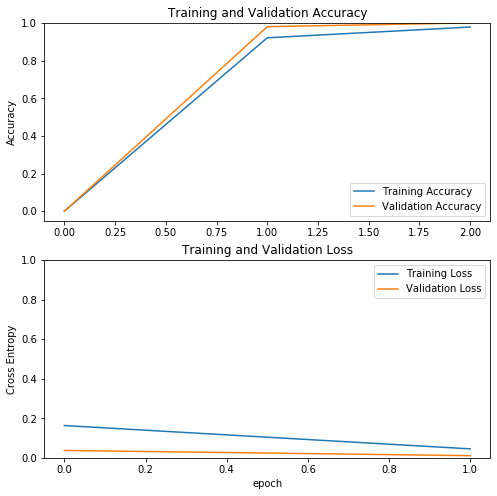

In [22]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine-tuning

In [25]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  157


In [26]:
# Fine-tune from this layer onwards
fine_tune_at = 130

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
catdogs_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.1*base_learning_rate),
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics=['accuracy'])

In [27]:
fine_tune_epochs = 2
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = catdogs_model.fit(train_dataset,
                                 epochs=total_epochs,
                                 initial_epoch=history.epoch[-1],
                                 validation_data=validation_dataset, 
                                 verbose=2)

Epoch 2/4
16/16 [==============================].0442 - accuracy: 0.98 - 4s 2s/step - loss: 0.0282 - accuracy: 0.99 - 5s 2s/step - loss: 0.0218 - accuracy: 0.99 - 6s 1s/step - loss: 0.0209 - accuracy: 0.99 - 6s 1s/step - loss: 0.0264 - accuracy: 0.98 - 7s 1s/step - loss: 0.0237 - accuracy: 0.98 - 8s 1s/step - loss: 0.0228 - accuracy: 0.99 - 8s 1s/step - loss: 0.0207 - accuracy: 0.99 - 9s 1s/step - loss: 0.0219 - accuracy: 0.98 - 10s 984ms/step - loss: 0.0215 - accuracy: 0.98 - 10s 954ms/step - loss: 0.0199 - accuracy: 0.99 - 11s 932ms/step - loss: 0.0223 - accuracy: 0.98 - 12s 911ms/step - loss: 0.0209 - accuracy: 0.99 - 13s 894ms/step - loss: 0.0275 - accuracy: 0.98 - 13s 877ms/step - loss: 0.0313 - accuracy: 0.98 - 14s 849ms/step - loss: 0.0299 - accuracy: 0.98 - 15s 967ms/step - loss: 0.0299 - accuracy: 0.9870 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/4
16/16 [==============================] ETA: 0s - loss: 0.0081 - accuracy: 1.00 - 12s 765ms/step - loss: 0.0206 - ac

In [28]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

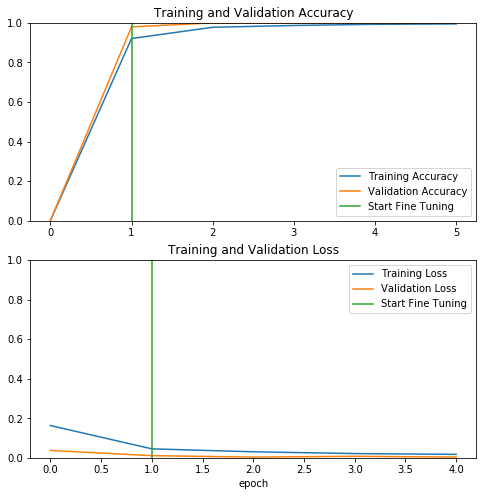

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()